In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
import dask
from dask.diagnostics import ProgressBar
from functools import partial


In [2]:
#setting progress bar visible
ProgressBar().register()
#making sure that xarray/dask splits large chunks while reading in data
dask.config.set({"array.slicing.split_large_chunks": True})

In [3]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 22)  # controls default text layout
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

#sns.set()
#plt.minorticks_on()

plt.rc('text', usetex=False)


In [4]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    #switch off for time series data
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num)
            #IOP03
            if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num)         
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)


def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds

In [5]:
def _subset_process_time_hom(ds,var,iop):    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
    #IOP03
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time_hom(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if ds.time.dtype == '<m8[ns]':
        if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22 22:00') + ds['time'].values
        
    #IOP03
    if ds.time.dtype == '<m8[ns]': 
        if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)


In [6]:
#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files_hom(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
            if iop=='iop03': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP3_parent_child1_hom/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','u','v','wtheta','wq']
            partial_func = partial(_subset_process_time_hom, var=var,iop=iop)
            # open_mfdataset() called without chunks argument will return dask arrays with chunk sizes 
            # equal to the individual files. Re-chunking the dataset after creation with ds.chunk() will 
            # lead to an ineffective use of memory and is not recommended
            ds = xr.open_mfdataset(file_list,preprocess=partial_func,chunks={'time': 8}) 
            ds.close()
            #check if the time index has only unique values 
            u, c = np.unique(ds.time.values, return_counts=True)
            #if not, keep the second, latest value for the ds
            if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')

            print('Member',str(member_num),'finished collecting data')
            
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2_parent_child1_hom/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP3_parent_child1_hom/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time_hom,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        #check if the time index has only unique values 
        u, c = np.unique(ds.time.values, return_counts=True)
        #if not, keep the second, latest value for the ds
        if np.sum(c > 1) > 0 : ds = ds.drop_duplicates(dim='time', keep='last')
        
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

Data input

In [7]:
#domain averaged profile data
profile_member_2_ds_iop02 = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop02')
profile_N02_member_2_ds_iop02 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop02')
profile_N03_member_2_ds_iop02 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop02')
profile_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDFslice','iop03')
profile_N02_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03')
profile_N03_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N03slice','iop03')


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.49631475657224655 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.470438826829195 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.5443409718573093 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.47176676243543625 seconds
['01.c

In [8]:
# #time series data for member2
# ts_N02_member_2_ds_iop02 = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N02slice','iop02')
# ts_N02_member_2_ds_iop03 = open_concat_member_files(2,'DATA_1D_TS_NETCDF_N02slice','iop03')


In [9]:
#ts_N02_member_2_ds_iop02

In [10]:
#ts_N02_ds_iop02 = xr.concat(open_concat_member_files(np.arange(1,9),'DATA_1D_TS_NETCDF_N02slice','iop02'),'ensemble')

In [11]:
#ts_N02_ds_iop02

In [12]:
#30 minute averaged data from one member
ensemble_member_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')


['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4127885662019253 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3300917372107506 seconds


In [13]:
#data from all the members
member_list = np.arange(1,9)

ensemble_ds_iop02_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_ds_iop02_N02 = xr.concat(ensemble_ds_iop02_N02_list,dim='ensemble')

#iop03
member_list = np.arange(0,8)

ensemble_ds_iop03_N02_list = open_concat_member_files(member_list,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_ds_iop03_N02 = xr.concat(ensemble_ds_iop03_N02_list,dim='ensemble')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  2.3626662492752075 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2718966342508793 seconds
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ches_IOP2.10214', '06.ches_IOP2.17190', '07.ches_IOP2.19176']
Member 3 finished collecting data
Done with member 3  Time elapsed  2.015141487121582 seconds
['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  2.37322

In [14]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

In [15]:
#subset the N02 data for the 10x10 km2 domain
x_min = 449-167
x_max = 449+168

y_min = 503-167
y_max = 503+168

#ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max))
ds_het_iop02 = ensemble_ds_iop02_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_iop02 = ensemble_member_ds_2_N02_iop02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

ds_het_iop03 = ensemble_ds_iop03_N02.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
ds_2_het_iop03 = ensemble_member_ds_2_N02_iop03.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

def adjust_axis(ds):    
    ds['x'] = ds.x - ds.x[0]
    ds['y'] = ds.y - ds.y[0]
    ds['xu'] = ds.xu - ds.xu[0]
    ds['yv'] = ds.yv - ds.yv[0]
    
    
    return (ds)


ds_het_iop02 = adjust_axis(ds_het_iop02)
ds_2_het_iop02 = adjust_axis(ds_2_het_iop02)

ds_het_iop03 = adjust_axis(ds_het_iop03)
ds_2_het_iop03 = adjust_axis(ds_2_het_iop03)



Time series of near surface H, LE and buoyancy fluxes from N02:

[########################################] | 100% Completed | 101.51 ms
[########################################] | 100% Completed | 201.64 ms
[########################################] | 100% Completed | 301.91 ms
[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 201.66 ms
[########################################] | 100% Completed | 301.94 ms
[########################################] | 100% Completed | 101.29 ms
[########################################] | 100% Completed | 201.89 ms
[########################################] | 100% Completed | 301.58 ms
[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.82 ms
[########################################] | 100% Completed | 201.46 ms
[########################################] | 100% Completed | 102.21 ms
[########################################] | 100% Completed | 20

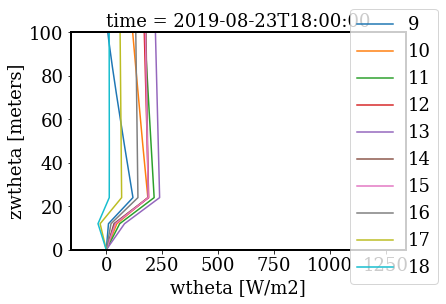

In [29]:
IOP02_time_array = ds_2_het_iop02.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T18:00:00.000000000')).time[::2]

fig, axis = plt.subplots()

for i, time_step in enumerate(IOP02_time_array):
    profile_N02_member_2_ds_iop02.wtheta.sel(time=time_step).plot(y='zwtheta', ax = axis, label = str(i+9))
    axis.set_ylim([0,100])
fig.legend()

The maximum near-surface heat flux is at the canopy top = 36 m.

In [ ]:
#Extract domain mean total flux time series from the profile data at 36 m.


In [16]:
#above canopy fluxes
def above_canopy_fluxes(ds,w_level):
    
    wtheta = calculate_turb_flux(ds)['wtheta_turb_energy'].sel(zw_3d=w_level).compute()#.mean('x').mean('y')
    wq = calculate_turb_flux(ds)['wq_turb_energy'].sel(zw_3d=w_level).compute()#.mean('x').mean('y')
    theta = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level)#.mean('x').mean('y')

    wtheta_v = ((wtheta/(1.17*1005) + 0.61*theta*wq/(1.17*2501*1000))*(1.17*1005)).compute()
    
    return wtheta, wq, wtheta_v

In [18]:
#iop02    
ds = ds_2_het_iop02.sel(zw_3d=slice(0,200),time=slice('2019-08-23T05:00:00.000000000','2019-08-23T20:00:01.200000000'))
w_level = 36
wtheta_iop02, wq_iop02, wtheta_v_iop02 = above_canopy_fluxes(ds,w_level)

#iop03    
ds = ds_2_het_iop03.sel(zw_3d=slice(0,200),time=slice('2019-09-24T05:00:00.000000000','2019-09-24T20:00:01.200000000'))
w_level = 36
wtheta_iop03, wq_iop03, wtheta_v_iop03 = above_canopy_fluxes(ds,w_level)


[########################################] | 100% Completed | 7.80 sms
[########################################] | 100% Completed | 14.00 ss
[########################################] | 100% Completed | 6.75 sms
[########################################] | 100% Completed | 6.65 sms
[########################################] | 100% Completed | 7.56 sms
[########################################] | 100% Completed | 5.34 sms


In [20]:
wtheta_iop02.time

<xarray.DataArray 'time' (time: 31)>
array(['2019-08-23T05:00:00.000000000', '2019-08-23T05:30:00.000000000',
       '2019-08-23T06:00:00.000000000', '2019-08-23T06:30:00.000000000',
       '2019-08-23T07:00:00.000000000', '2019-08-23T07:30:00.000000000',
       '2019-08-23T08:00:00.000000000', '2019-08-23T08:30:00.000000000',
       '2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000', '2019-08-23T16:30:00.000000000',
       '2019-08-23T17:00:00.000000000', '2019-08-23T17:30:00.000000000',
       '2019-08-23T18:00:00.000000000', '2019-08-23T18:30:00.000000000',
       '2019-08-23T19:00:00.000000000', '2019-08-23T19:30:00.000000000',
       '2019-08-23T20:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T05:00:00 ... 2019-08-23T20:00:00
    zw_3d    float64 36.0

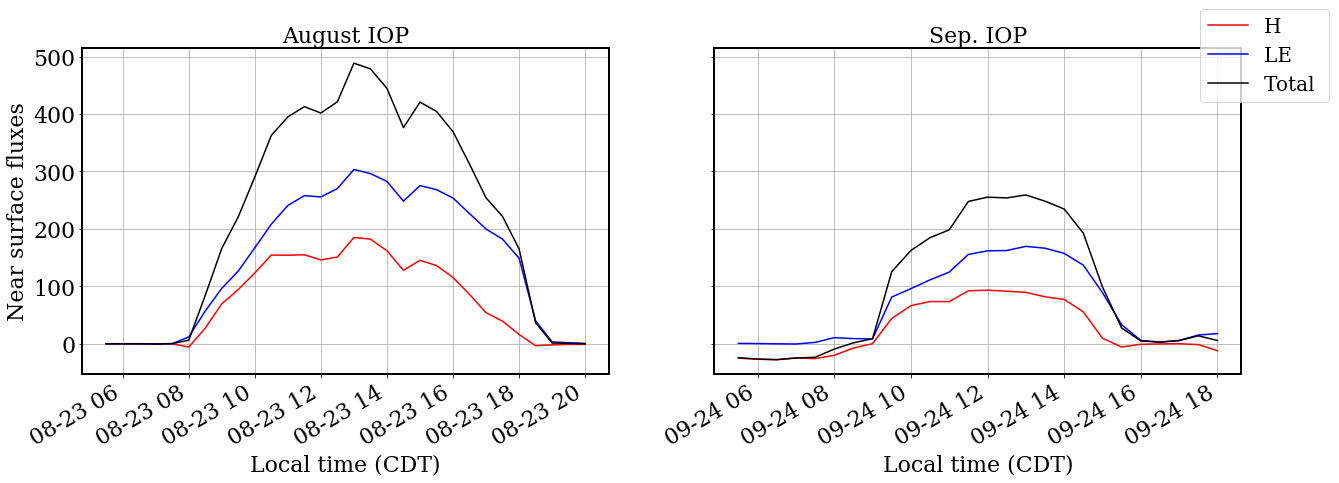

In [21]:
#IOP02 surface flux plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6), sharey=True)

wtheta_iop02[1:].mean('x').mean('y').plot(ax=ax1,color='red')

wq_iop02[1:].mean('x').mean('y').plot(ax=ax1,color='blue')

(wtheta_iop02[1:].mean('x').mean('y') + wq_iop02[1:].mean('x').mean('y')).plot(ax=ax1,color='black')

ax1.grid(True)
ax1.set_ylabel('Near surface fluxes')
ax1.set_xlabel('Local time (CDT)')
ax1.set_title('August IOP')

#IOP03 surface flux plot
wtheta_iop03[1:].mean('x').mean('y').plot(ax=ax2,color='red')

wq_iop03[1:].mean('x').mean('y').plot(ax=ax2,color='blue')

(wtheta_iop03[1:].mean('x').mean('y') + wq_iop03[1:].mean('x').mean('y')).plot(ax=ax2,color='black')

ax2.grid(True)
ax2.set_title('Sep. IOP')
ax2.set_ylabel('')
ax2.set_xlabel('Local time (CDT)')

fig.legend(['H ','LE ', 'Total '],fontsize=20)
fig.subplots_adjust(right=0.93)


Calculate a time series of zi_theta from the 30 min avg data for $\theta_{v}$

[########################################] | 100% Completed | 101.34 ms
[########################################] | 100% Completed | 201.32 ms
[########################################] | 100% Completed | 201.32 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 201.13 ms
[########################################] | 100% Completed | 301.30 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 201.25 ms
[########################################] | 100% Completed | 301.74 ms
[########################################] | 100% Completed | 101.60 ms
[########################################] | 100% Completed | 201.08 ms
[########################################] | 100% Completed | 301.37 ms
[########################################] | 100% Completed | 100.97 ms
[########################################] | 100% Completed | 20

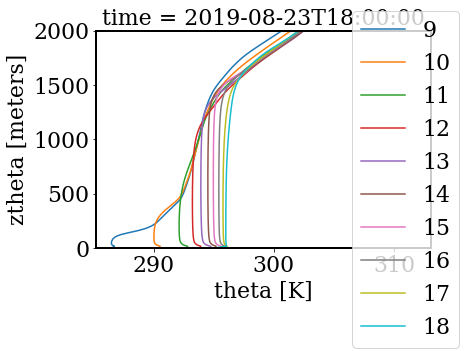

In [46]:
IOP02_time_array = ds_2_het_iop02.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T18:00:00.000000000')).time[::2]

fig, axis = plt.subplots()

for i, time_step in enumerate(IOP02_time_array):
    profile_N02_member_2_ds_iop02.theta.sel(time=time_step).plot(y='ztheta', ax = axis, label = str(i+9))
    axis.set_ylim([0,2000])
fig.legend()

[########################################] | 100% Completed | 101.11 ms
[########################################] | 100% Completed | 201.80 ms
[########################################] | 100% Completed | 301.50 ms


(0.0, 100.0)

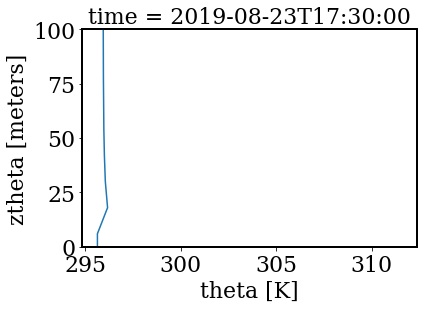

In [56]:
time_step = '2019-08-23T17:30:00.000000000'
fig, axis = plt.subplots()
profile_N02_member_2_ds_iop02.theta.sel(time=time_step).plot(y='ztheta', label = str(i+9))
axis.set_ylim([0,100])

Wanted to have a look at the near surface for 18:00. Surface is cold, but canopy at 36 is still warmer than air. There is a non-zero buoyancy flux too. So 17:30-18:00, CBL exists. Surface cooling starts after 18:00 and a near-surface stable layer starts forming then on. \
I can show zi time series from 08-18

I can subset the data vertically at 2000 for all times. Let's see what happens:
Nothing great, the noise above ABL obfuscates the differentiation.

[########################################] | 100% Completed | 101.68 ms
[########################################] | 100% Completed | 201.51 ms
[########################################] | 100% Completed | 301.81 ms
[########################################] | 100% Completed | 101.24 ms
[########################################] | 100% Completed | 201.29 ms
[########################################] | 100% Completed | 301.61 ms


(0.0, 1700.0)

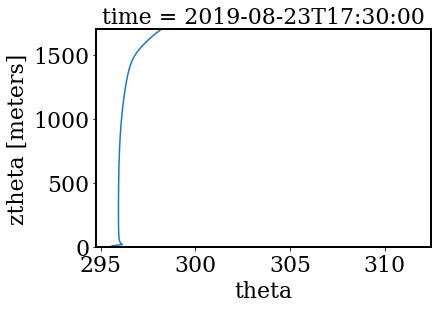

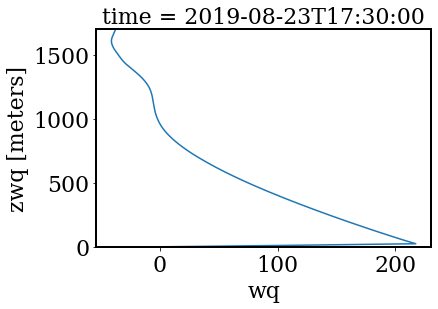

In [106]:
time_step = '2019-08-23T17:30:00.000000000'
fig, axis = plt.subplots()
profile_N02_member_2_ds_iop02.theta.resample(time='30T').mean().sel(time=time_step).plot(y='ztheta', label = str(i+9))
axis.set_ylim([0,1700])

fig, axis = plt.subplots()
profile_N02_member_2_ds_iop02.wq.resample(time='30T').mean().sel(time=time_step).plot(y='zwq', label = str(i+9))
axis.set_ylim([0,1700])

In [101]:
zi_theta_av_list = []

IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:00.000000000')).values
vertical_slice = [200, 200, 600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700, 1700, 1700, 1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta_v = ds_2_het_iop02.theta.sel(time = time_step) + 0.61*ds_2_het_iop02.q.sel(time = time_step)
    zi_xy_av = (theta_v.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02 = xr.concat(zi_theta_av_list,'time')

[########################################] | 100% Completed | 403.83 ms
[########################################] | 100% Completed | 503.81 ms
[########################################] | 100% Completed | 603.73 ms
[########################################] | 100% Completed | 403.69 ms
[########################################] | 100% Completed | 503.61 ms
[########################################] | 100% Completed | 603.79 ms
[########################################] | 100% Completed | 504.37 ms
[########################################] | 100% Completed | 604.40 ms
[########################################] | 100% Completed | 704.07 ms
[########################################] | 100% Completed | 605.21 ms
[########################################] | 100% Completed | 705.06 ms
[########################################] | 100% Completed | 805.32 ms
[########################################] | 100% Completed | 706.38 ms
[########################################] | 100% Completed | 80

In [102]:
zi_theta_iop02

<xarray.DataArray 'zu_3d' (time: 20)>
array([  49.6941145 ,   83.47664068,  127.17374916,  186.31875251,
        396.70267766,  489.81241256,  774.62413901, 1191.6998708 ,
       1237.6693072 , 1401.17308978, 1551.37994208, 1531.30430831,
       1598.47618623, 1612.84239697, 1616.62775674, 1625.69333036,
       1626.38023613, 1575.12149699,  811.33809757,  475.33766986])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T17:30:00

In [16]:
IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:00.000000000')).values

In [108]:
zi_theta_av_list = []

IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:00.000000000')).values
vertical_slice = [200, 200, 600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700, 1700, 1700, 1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta_v = ds_2_het_iop02.theta.sel(time = time_step) + 0.61*ds_2_het_iop02.q.sel(time = time_step)
    zi_xy_av = (theta_v.sel(zu_3d=slice(40,vertical_slice[i])).mean('x').mean('y').differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02_av = xr.concat(zi_theta_av_list,'time')

[########################################] | 100% Completed | 304.02 ms
[########################################] | 100% Completed | 302.84 ms
[########################################] | 100% Completed | 403.73 ms
[########################################] | 100% Completed | 404.16 ms
[########################################] | 100% Completed | 806.25 ms
[########################################] | 100% Completed | 403.68 ms
[########################################] | 100% Completed | 403.80 ms
[########################################] | 100% Completed | 403.69 ms
[########################################] | 100% Completed | 403.80 ms
[########################################] | 100% Completed | 403.81 ms
[########################################] | 100% Completed | 403.95 ms
[########################################] | 100% Completed | 403.61 ms
[########################################] | 100% Completed | 403.91 ms
[########################################] | 100% Completed | 40

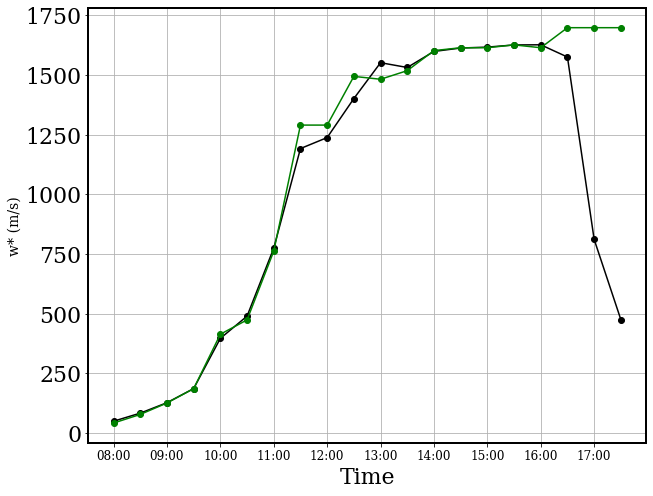

In [109]:
time_stamp =  (zi_theta_iop02.time.dt.strftime('%H:%M'))


fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,zi_theta_iop02.values,'-o',color='black')
ax1.plot(time_stamp,zi_theta_iop02_av.values,'-o',color='green')
#ax1.axvline(x='13:00')
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

Mismatch between the domain mean of local zi_thetav and zi_thetav calculated from domain mean of theta_v after 16:00. After 17:00 the differences are pronounced; the surface fluxes start getting weak and ABL top could be more diffused, leading to such differences between the two approaches. So, will go ahead with values from 08:30-1600

In [21]:
zi_theta_av_list = []

IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:00.000000000')).values
vertical_slice = [200, 200, 600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700, 1700, 1700, 1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta_v = ds_2_het_iop02.theta.sel(time = time_step)*(1 + 0.61*ds_2_het_iop02.q.sel(time = time_step))
    zi_xy_av = (theta_v.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02 = xr.concat(zi_theta_av_list,'time')

[########################################] | 100% Completed | 1.92 sms
[########################################] | 100% Completed | 1.91 ss
[########################################] | 100% Completed | 2.02 ss
[########################################] | 100% Completed | 1.81 sms
[########################################] | 100% Completed | 2.32 ss
[########################################] | 100% Completed | 2.62 ss
[########################################] | 100% Completed | 2.02 ss
[########################################] | 100% Completed | 2.42 ss
[########################################] | 100% Completed | 2.62 ss
[########################################] | 100% Completed | 2.52 ss
[########################################] | 100% Completed | 3.32 ss
[########################################] | 100% Completed | 2.32 ss
[########################################] | 100% Completed | 2.72 ss
[########################################] | 100% Completed | 3.02 ss
[#################

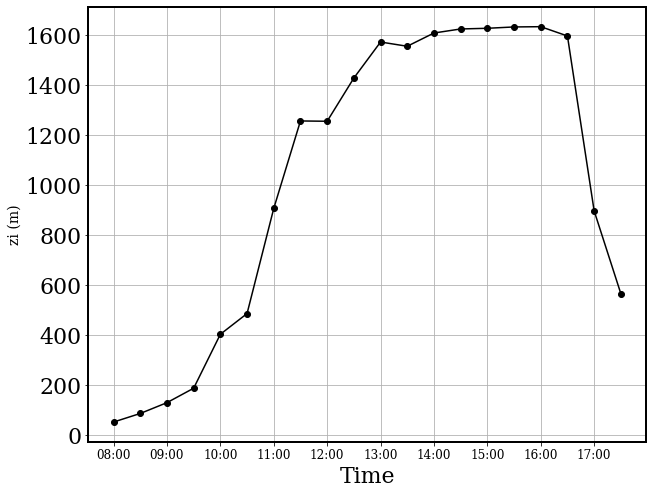

In [22]:
time_stamp =  (zi_theta_iop02.time.dt.strftime('%H:%M'))


fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,zi_theta_iop02.values,'-o',color='black')
#ax1.axvline(x='13:00')
ax1.set_ylabel('zi (m)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [24]:
zi_theta_iop02.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:00.000000000'))

<xarray.DataArray 'zu_3d' (time: 15)>
array([ 128.4789129 ,  186.29704611,  402.40461573,  485.38067276,
        906.50266875, 1256.90609044, 1255.68711072, 1428.77175317,
       1573.09371352, 1556.12316329, 1609.16728002, 1625.39083092,
       1628.12380486, 1633.47266652, 1634.52013366])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T09:00:00 ... 2019-08-23T16:00:00

Just checking the same with $\theta$ profiles:

In [17]:
zi_theta_av_list = []

IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:00.000000000')).values
vertical_slice = [200, 200, 600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700, 1700, 1700, 1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta = ds_2_het_iop02.theta.sel(time = time_step) 
    zi_xy_av = (theta.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02 = xr.concat(zi_theta_av_list,'time')

[########################################] | 100% Completed | 101.79 ms
[########################################] | 100% Completed | 101.48 ms
[########################################] | 100% Completed | 403.74 ms
[########################################] | 100% Completed | 302.87 ms
[########################################] | 100% Completed | 504.35 ms
[########################################] | 100% Completed | 504.51 ms
[########################################] | 100% Completed | 705.70 ms
[########################################] | 100% Completed | 907.61 ms
[########################################] | 100% Completed | 807.16 ms
[########################################] | 100% Completed | 907.24 ms
[########################################] | 100% Completed | 907.48 ms
[########################################] | 100% Completed | 907.90 ms
[########################################] | 100% Completed | 907.53 ms
[########################################] | 100% Completed | 1.

In [18]:
zi_theta_iop02

<xarray.DataArray 'zu_3d' (time: 20)>
array([  49.69229673,   83.47108042,  127.17054132,  186.31918022,
        396.68877701,  489.81914903,  774.49668078, 1191.30455781,
       1237.60654043, 1401.07963466, 1551.29792827, 1531.22036979,
       1598.45180664, 1612.79983961, 1616.59161506, 1625.67354867,
       1626.35585654, 1575.01638672,  810.96449098,  474.94267766])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T17:30:00

In [19]:
zi_theta_av_list = []

IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:00.000000000')).values
vertical_slice = [200, 200, 600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700, 1700, 1700, 1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta = ds_2_het_iop02.theta.sel(time = time_step)
    zi_xy_av = (theta.sel(zu_3d=slice(40,vertical_slice[i])).mean('x').mean('y').differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02_av = xr.concat(zi_theta_av_list,'time')

[########################################] | 100% Completed | 101.79 ms
[########################################] | 100% Completed | 101.49 ms
[########################################] | 100% Completed | 101.47 ms
[########################################] | 100% Completed | 101.45 ms
[########################################] | 100% Completed | 101.42 ms
[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 101.47 ms
[########################################] | 100% Completed | 202.14 ms
[########################################] | 100% Completed | 202.15 ms
[########################################] | 100% Completed | 202.22 ms
[########################################] | 100% Completed | 202.03 ms
[########################################] | 100% Completed | 201.90 ms
[########################################] | 100% Completed | 202.18 ms
[########################################] | 100% Completed | 20

In [20]:
zi_theta_iop02_av

<xarray.DataArray 'zu_3d' (time: 20)>
array([  42.,   78.,  126.,  186.,  414.,  474.,  762., 1290., 1290.,
       1494., 1482., 1518., 1602., 1626., 1614., 1626., 1614., 1698.,
       1698., 1698.])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T17:30:00

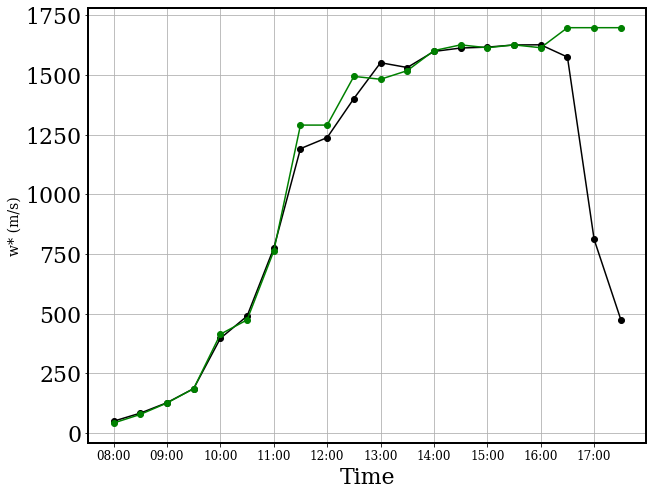

In [21]:
time_stamp =  (zi_theta_iop02.time.dt.strftime('%H:%M'))


fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,zi_theta_iop02.values,'-o',color='black')
ax1.plot(time_stamp,zi_theta_iop02_av.values,'-o',color='green')
#ax1.axvline(x='13:00')
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [17]:
def calc_u_star(ds,w_level):
    #above canopy momentum fluxes
    w_av = ds.w.sel(zw_3d=w_level)#[1:]

    uw_av = ds.uw.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'xu': 'x'}).interp_like(ds.v)
    u_av = ds.u.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'xu': 'x'}).interp_like(ds.v)#[1:]
    uprime_wprime = (uw_av - u_av*w_av)

    vw_av = ds.vw.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'yv': 'y'}).interp_like(ds.u)#[1:]#[1:]
    v_av = ds.v.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=w_level).rename({'yv': 'y'}).interp_like(ds.u)#[1:]
    vprime_wprime = (vw_av - v_av*w_av)

    time_stamp =  (uw_av['time'].dt.strftime('%H:%M'))

    #above canopy u*
    u_star = (uprime_wprime**2 + vprime_wprime**2)**(0.25)
    
    return u_star

def u_star_list(ds,time_array):
    
    u_star_list = []
    
    for time_step in time_array:
        u_star_val = calc_u_star(ds.sel(zw_3d = slice (0,60),zu_3d = slice (0,60),time=time_step),36).mean().compute().values
        u_star_list.append(u_star_val)
    return u_star_list

In [51]:
IOP02_time_array = np.asarray(['2019-08-23T08:00:00.000000000','2019-08-23T08:30:00.000000000',
       '2019-08-23T09:00:00.000000000', '2019-08-23T09:30:00.000000000',
       '2019-08-23T10:00:00.000000000', '2019-08-23T10:30:00.000000000',
       '2019-08-23T11:00:00.000000000', '2019-08-23T11:30:00.000000000',
       '2019-08-23T12:00:00.000000000', '2019-08-23T12:30:00.000000000',
       '2019-08-23T13:00:00.000000000', '2019-08-23T13:30:00.000000000',
       '2019-08-23T14:00:00.000000000', '2019-08-23T14:30:00.000000000',
       '2019-08-23T15:00:00.000000000', '2019-08-23T15:30:00.000000000',
       '2019-08-23T16:00:00.000000000', '2019-08-23T16:30:00.000000000',
       '2019-08-23T17:00:00.000000000','2019-08-23T17:30:00.000000000'],
      dtype='datetime64[ns]')

In [52]:
u_star_list_iop02_1 = u_star_list(ds_2_het_iop02,IOP02_time_array)

[########################################] | 100% Completed | 102.23 ms
[########################################] | 100% Completed | 102.17 ms
[########################################] | 100% Completed | 102.16 ms
[########################################] | 100% Completed | 102.12 ms
[########################################] | 100% Completed | 102.20 ms
[########################################] | 100% Completed | 102.19 ms
[########################################] | 100% Completed | 102.20 ms
[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 102.16 ms
[########################################] | 100% Completed | 102.16 ms
[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 102.22 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 10

In [53]:
u_star_list_iop02_1

[array(0.13250938, dtype=float32),
 array(0.24337365, dtype=float32),
 array(0.2461864, dtype=float32),
 array(0.2744869, dtype=float32),
 array(nan, dtype=float32),
 array(0.39817616, dtype=float32),
 array(0.42797342, dtype=float32),
 array(0.4454284, dtype=float32),
 array(0.41556457, dtype=float32),
 array(0.41464233, dtype=float32),
 array(0.41703707, dtype=float32),
 array(0.43543258, dtype=float32),
 array(0.40890935, dtype=float32),
 array(0.3643331, dtype=float32),
 array(0.37420803, dtype=float32),
 array(0.3747994, dtype=float32),
 array(nan, dtype=float32),
 array(0.3362072, dtype=float32),
 array(0.30676702, dtype=float32),
 array(0.27559936, dtype=float32)]

Some ensemble members have nan values for some uw and vw values. This happened if the runs stopped in the middle of an averaging peiod. Here, I am gap filling the u star time series for one member from values from another member, which is reasonable for the 30 minute, domain means.

In [55]:
ds = open_concat_member_files(4,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:01.200000000'))
ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
u_star_list_iop02_4 = u_star_list(ds,IOP02_time_array)


['01.ches_IOP2.5461', '02.ches_IOP2.19281', '03.ches_IOP2.11295', '04.ches_IOP2.14610', '05.ches_IOP2.24393', '06. ches_IOP2.29130', '07. ches_IOP2.18966']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.32240088284015656 seconds
[########################################] | 100% Completed | 102.19 ms
[########################################] | 100% Completed | 102.06 ms
[########################################] | 100% Completed | 102.09 ms
[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 102.14 ms
[########################################] | 100% Completed | 102.35 ms
[########################################] | 100% Completed | 102.30 ms
[########################################] | 100% Completed | 102.21 ms
[########################################] | 100% Completed | 102.23 ms
[########################################] | 100% Completed | 102.12 ms
[###########################

In [56]:
u_star_list_iop02_1[4] = u_star_list_iop02_4[4]
u_star_list_iop02_1[-4]= u_star_list_iop02_4[-4]

In [160]:
#calculate obukhov length time series, from 08-1730
k = 0.4
g = 9.8

#IOP02
#above canopy u*
u_star = np.asarray(u_star_list_iop02_1)

ds = ds_2_het_iop02.sel(zu_3d=slice(0,200)).sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:01.200000000'))

theta = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=36)#.mean('x').mean('y')
q = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=36)#.mean('x').mean('y')
theta_v = (theta*(1 + 0.61*q)).mean('x').mean('y')

wtheta_v = (wtheta_v_iop02/(1.17*1005)).sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T17:30:01.200000000')).mean('x').mean('y')

ol_iop02 = -((u_star**3)*theta_v)/(k*g*wtheta_v).compute()
#since fluxes are in w/m2, converting them back to kinematic units
# (and ol to m)

obukhov_length_iop02 = np.asarray(ol_iop02)


[########################################] | 100% Completed | 21.47 ss


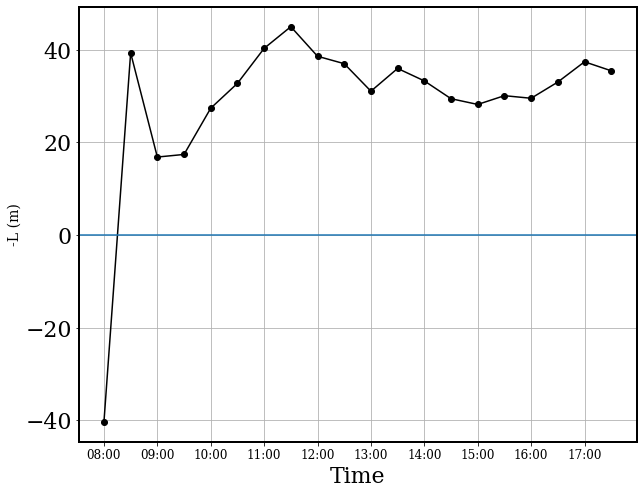

In [79]:

time_stamp =  (ol['time'].dt.strftime('%H:%M'))

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp[1:],-obukhov_length[1:],'-o',color='black')
ax1.axhline(y=0)
ax1.grid(True)
ax1.set_ylabel('-L (m)',fontsize=14)
#ax2.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
#ax2.grid(True)
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)


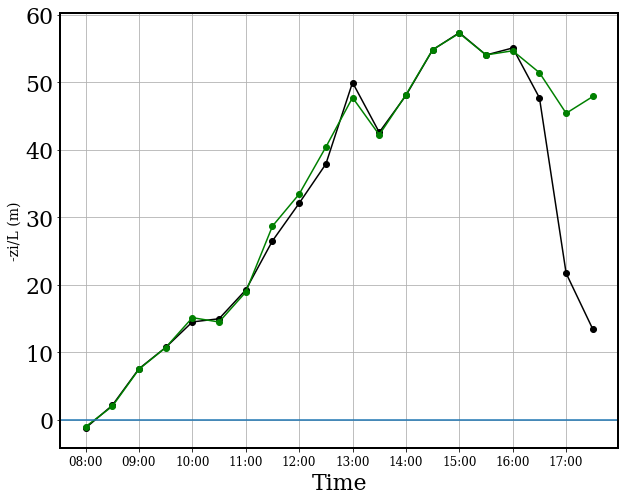

In [130]:
time_stamp =  (ol['time'].dt.strftime('%H:%M'))

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp,-zi_theta_iop02.values/obukhov_length,'-o',color='black')
ax1.plot(time_stamp,-zi_theta_iop02_av.values/obukhov_length,'-o',color='green')
ax1.axhline(y=0)
ax1.grid(True)
ax1.set_ylabel('-zi/L (m)',fontsize=14)
#ax2.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
#ax2.grid(True)
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)


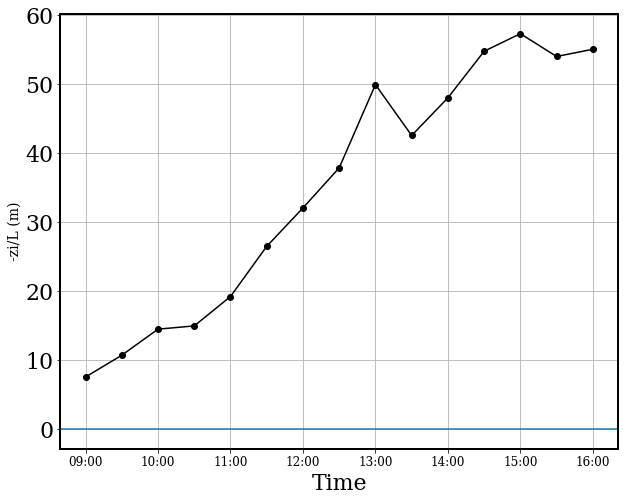

In [92]:

time_stamp =  (ol['time'].dt.strftime('%H:%M'))

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp[2:-3],-zi_theta_iop02[2:-3].values/obukhov_length[2:-3],'-o',color='black')
#ax1.plot(time_stamp,-zi_theta_iop02_av.values/obukhov_length,'-o',color='green')
ax1.axhline(y=0)
ax1.grid(True)
ax1.set_ylabel('-zi/L (m)',fontsize=14)
#ax2.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
#ax2.grid(True)
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)

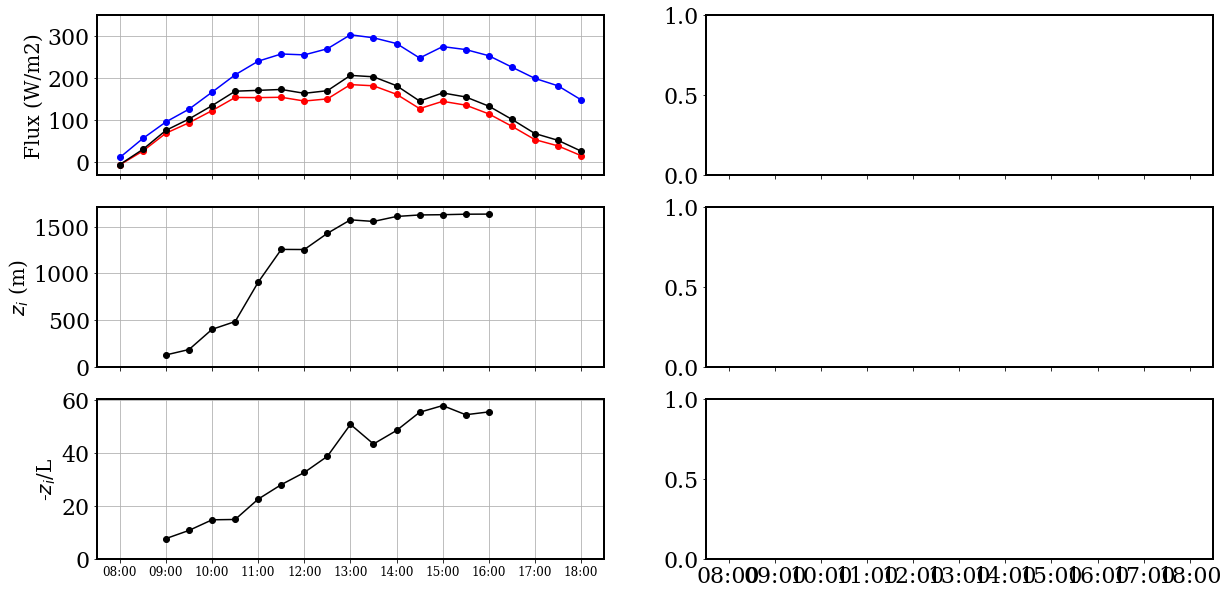

In [143]:
time_stamp = wtheta_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000'))['time'].dt.strftime('%H:%M')

fig, (ax1) = plt.subplots(3,2,figsize=(20,10),sharex=True)

H=wtheta_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000')).mean('x').mean('y').values
LE=wq_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000')).mean('x').mean('y').values
bf=wtheta_v_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000')).mean('x').mean('y').values
ax1[0,0].plot(time_stamp,H,'-o',color='red')
ax1[0,0].plot(time_stamp,LE,'-o',color='blue')
ax1[0,0].plot(time_stamp,bf,'-o',color='black')
ax1[0,0].set_ylabel('Flux (W/m2)',fontsize=20)
ax1[0,0].set_ylim([-30,350])
ax1[0,0].set_yticks([0,100,200,300])
ax1[0,0].grid(True)

ax1[0,0].grid(True)
ax1[1,0].plot(time_stamp[2:-4],zi_theta_iop02[2:-3],'-o',color='black')
ax1[1,0].set_ylabel('$z_{i}$ (m)',fontsize=20)
ax1[1,0].set_yticks([0,500,1000,1500])
ax1[1,0].grid(True)

ax1[2,0].plot(time_stamp[2:-4],-zi_theta_iop02[2:-3]/obukhov_length[2:-3],'-o',color='black')
ax1[2,0].set_ylabel('-$z_{i}$/L',fontsize=20)
ax1[2,0].set_yticks([0,20,40,60])
ax1[2,0].grid(True)

tick_spacing = 2
ax1[2,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1[2,0].tick_params(axis="x", labelsize=12)




iop03

[########################################] | 100% Completed | 101.91 ms
[########################################] | 100% Completed | 201.88 ms
[########################################] | 100% Completed | 301.81 ms
[########################################] | 100% Completed | 101.16 ms
[########################################] | 100% Completed | 101.69 ms
[########################################] | 100% Completed | 201.54 ms
[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 201.55 ms
[########################################] | 100% Completed | 301.27 ms
[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 201.28 ms
[########################################] | 100% Completed | 201.37 ms
[########################################] | 100% Completed | 101.43 ms
[########################################] | 100% Completed | 20

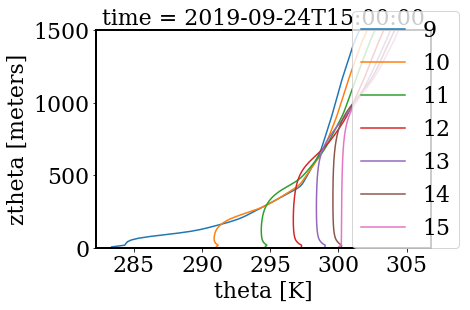

In [151]:
IOP03_time_array = ds_2_het_iop03.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T15:00:00.000000000')).time[::2]

fig, axis = plt.subplots()

for i, time_step in enumerate(IOP03_time_array):
    profile_N02_member_2_ds_iop03.theta.sel(time=time_step).plot(y='ztheta', ax = axis, label = str(i+9))
    axis.set_ylim([0,1500])
fig.legend()

[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 101.18 ms


(0.0, 1100.0)

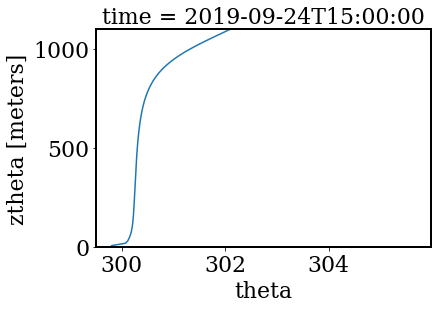

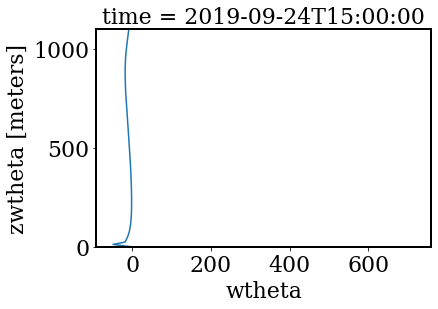

In [136]:
time_step = '2019-09-24T15:00:00.000000000'
fig, axis = plt.subplots()
profile_N02_member_2_ds_iop03.theta.resample(time='30T').mean().sel(time=time_step).plot(y='ztheta', label = time_step)
axis.set_ylim([0,1100])

fig, axis = plt.subplots()
profile_N02_member_2_ds_iop03.wtheta.resample(time='30T').mean().sel(time=time_step).plot(y='zwtheta', label = time_step)
axis.set_ylim([0,1100])

Plot zi values from 09-14:30

In [170]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

In [12]:
#abl height

zi_theta_av_list = []

IOP03_time_array = ensemble_member_ds_2_N02_iop03.time.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:00.000000000')).values
vertical_slice =  [200,300,300,400,
                   500,600,800,800,
                   900,1000,1100,1100]    

for i, time_step in enumerate(IOP03_time_array):
    theta_v = ds_2_het_iop03.theta.sel(time = time_step)*(1 + 0.61*ds_2_het_iop03.q.sel(time = time_step))
    zi_xy_av = (theta_v.sel(zu_3d=slice(40,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)

zi_theta_iop03 = xr.concat(zi_theta_av_list,'time')




[########################################] | 100% Completed | 303.56 ms
[########################################] | 100% Completed | 302.92 ms
[########################################] | 100% Completed | 302.73 ms
[########################################] | 100% Completed | 302.70 ms
[########################################] | 100% Completed | 302.91 ms
[########################################] | 100% Completed | 302.67 ms
[########################################] | 100% Completed | 302.65 ms
[########################################] | 100% Completed | 303.13 ms
[########################################] | 100% Completed | 302.73 ms
[########################################] | 100% Completed | 302.85 ms
[########################################] | 100% Completed | 302.52 ms
[########################################] | 100% Completed | 302.61 ms


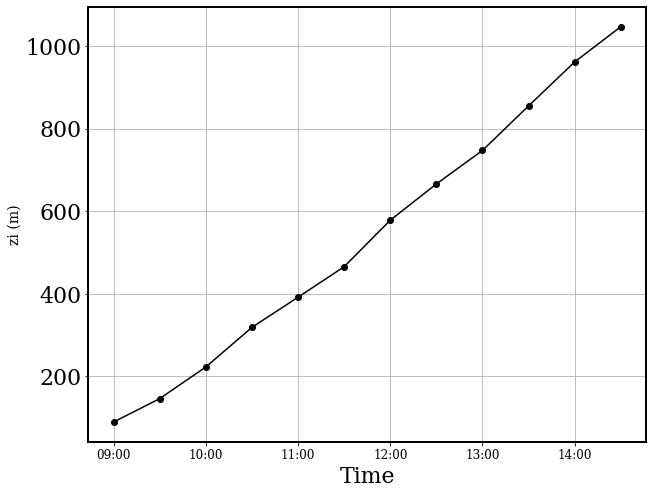

In [13]:
time_stamp =  (zi_theta_iop03.time.dt.strftime('%H:%M'))


fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
ax1.plot(time_stamp,zi_theta_iop03.values,'-o',color='black')
ax1.set_ylabel('zi (m)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

Updated ustar claculatons in 2.surface_length_scales notebook

In [144]:
u_star_list_iop03_1 = u_star_list(ds_2_het_iop03,IOP03_time_array)


[########################################] | 100% Completed | 606.35 ms
[########################################] | 100% Completed | 504.90 ms
[########################################] | 100% Completed | 504.31 ms
[########################################] | 100% Completed | 605.36 ms
[########################################] | 100% Completed | 505.01 ms
[########################################] | 100% Completed | 504.96 ms
[########################################] | 100% Completed | 504.82 ms
[########################################] | 100% Completed | 504.94 ms
[########################################] | 100% Completed | 404.32 ms
[########################################] | 100% Completed | 605.35 ms
[########################################] | 100% Completed | 504.79 ms
[########################################] | 100% Completed | 505.01 ms


In [145]:
u_star_list_iop03_1

[array(0.11458225, dtype=float32),
 array(0.35145557, dtype=float32),
 array(0.4338147, dtype=float32),
 array(0.4937438, dtype=float32),
 array(0.5262037, dtype=float32),
 array(0.5754108, dtype=float32),
 array(0.6081538, dtype=float32),
 array(nan, dtype=float32),
 array(0.6460324, dtype=float32),
 array(0.6552553, dtype=float32),
 array(0.6548055, dtype=float32),
 array(0.62964904, dtype=float32)]

In [151]:
ds = open_concat_member_files(4,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:01.200000000'))
ds = ds.isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
u_star_list_iop03_4 = u_star_list(ds,IOP03_time_array)
u_star_list_iop03_4

['01.ches_IOP3.16528', '02.ches_IOP3.28527', '03.ches_IOP3.21926', '04.ches_IOP3.28821', '05.ches_IOP3.12923', '06.ches_IOP3.26673', '07.ches_IOP3.9411', '08.ches_IOP3.4995']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.34589248336851597 seconds
[########################################] | 100% Completed | 102.73 ms
[########################################] | 100% Completed | 102.09 ms
[########################################] | 100% Completed | 102.19 ms
[########################################] | 100% Completed | 102.06 ms
[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 102.18 ms
[########################################] | 100% Completed | 102.04 ms
[########################################] | 100% Completed | 102.07 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 102.12 ms
[########

[array(0.10826582, dtype=float32),
 array(0.3454594, dtype=float32),
 array(0.42772824, dtype=float32),
 array(0.48567945, dtype=float32),
 array(0.5262542, dtype=float32),
 array(0.5755739, dtype=float32),
 array(0.60749817, dtype=float32),
 array(0.6219053, dtype=float32),
 array(0.63899344, dtype=float32),
 array(0.6477162, dtype=float32),
 array(nan, dtype=float32),
 array(0.6270505, dtype=float32)]

In [152]:
u_star_list_iop03_1[-5] = u_star_list_iop03_4[-5]

In [14]:
u_star_array_iop03 = [0.10734038, 0.346752  , 0.42885262, 0.4882605 , 0.5238576 ,
       0.573982  , 0.60698235, 0.6250409 , 0.63989866, 0.6486785 ,
       0.651481  , 0.62593067]

In [15]:
u_star_list_iop03_1 = u_star_array_iop03

In [18]:
#calculate obukhov length time series, from 08-1730
k = 0.4
g = 9.8

#IOP03
#above canopy u*
u_star = np.asarray(u_star_list_iop03_1)

ds = ds_2_het_iop03.sel(zu_3d=slice(0,200)).sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:01.200000000'))

theta = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=36)#.mean('x').mean('y')
q = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w).sel(zw_3d=36)#.mean('x').mean('y')
theta_v = (theta*(1 + 0.61*q)).mean('x').mean('y')

wtheta_v = (wtheta_v_iop03/(1.17*1005)).sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:01.200000000')).mean('x').mean('y')

ol_iop03 = -((u_star**3)*theta_v)/(k*g*wtheta_v).compute()
#since fluxes are in w/m2, converting them back to kinematic units
# (and ol to m)

obukhov_length_iop03 = np.asarray(ol_iop03)

[########################################] | 100% Completed | 8.46 sms


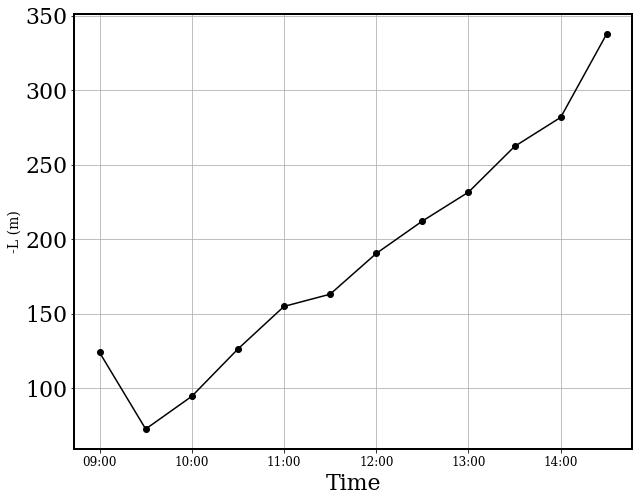

In [19]:

time_stamp =  (ol_iop03['time'].dt.strftime('%H:%M'))

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp,-obukhov_length_iop03,'-o',color='black')
#ax1.plot(time_stamp,-zi_theta_iop02_av.values/obukhov_length,'-o',color='green')

ax1.grid(True)
ax1.set_ylabel('-L (m)',fontsize=14)
#ax2.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
#ax2.grid(True)
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)

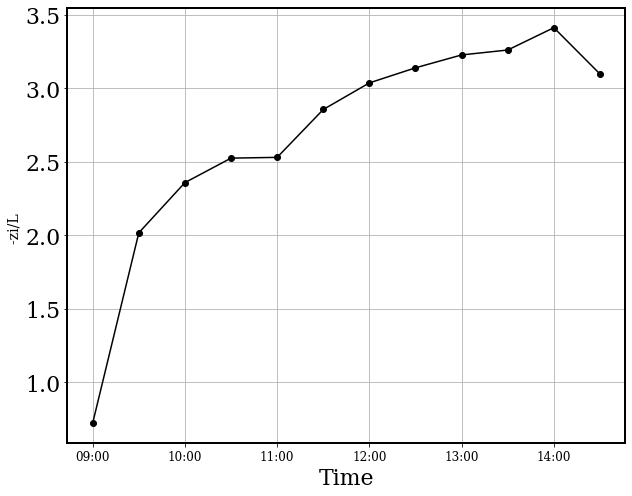

In [20]:

time_stamp =  (ol_iop03['time'].dt.strftime('%H:%M'))

fig, (ax1) = plt.subplots(1,1,figsize=(10,8))

ax1.plot(time_stamp,-zi_theta_iop03.values/obukhov_length_iop03,'-o',color='black')
#ax1.plot(time_stamp,-zi_theta_iop02_av.values/obukhov_length,'-o',color='green')

ax1.grid(True)
ax1.set_ylabel('-zi/L ',fontsize=14)
#ax2.set_ylabel('z_i (m)',fontsize=14)
ax1.set_xlabel('Time')
#ax2.grid(True)
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis="x", labelsize=12)

In [202]:
pwd()

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

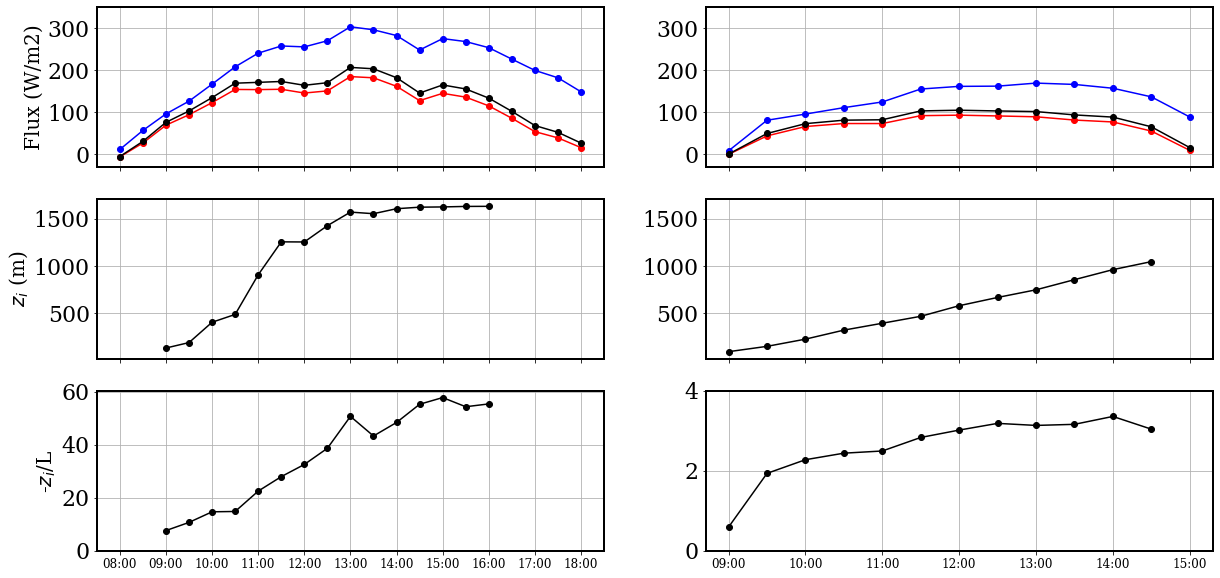

In [203]:
time_stamp = wtheta_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000'))['time'].dt.strftime('%H:%M')

fig, (ax1) = plt.subplots(3,2,figsize=(20,10),sharex='col')

#iop02
H=wtheta_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000')).mean('x').mean('y').values
LE=wq_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000')).mean('x').mean('y').values
bf=wtheta_v_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T18:00:00.000000000')).mean('x').mean('y').values
ax1[0,0].plot(time_stamp,H,'-o',color='red')
ax1[0,0].plot(time_stamp,LE,'-o',color='blue')
ax1[0,0].plot(time_stamp,bf,'-o',color='black')
ax1[0,0].set_ylabel('Flux (W/m2)',fontsize=20)
ax1[0,0].set_ylim([-30,350])
ax1[0,0].set_yticks([0,100,200,300])
ax1[0,0].grid(True)

ax1[1,0].plot(time_stamp[2:-4],zi_theta_iop02[2:-3],'-o',color='black')
ax1[1,0].set_ylabel('$z_{i}$ (m)',fontsize=20)
ax1[1,0].set_yticks([0,500,1000,1500])

ax1[1,0].grid(True)

ax1[2,0].plot(time_stamp[2:-4],-zi_theta_iop02[2:-3]/obukhov_length_iop02[2:-3],'-o',color='black')
ax1[2,0].set_ylabel('-$z_{i}$/L',fontsize=20)
ax1[2,0].set_yticks([0,20,40,60])
ax1[2,0].grid(True)

tick_spacing = 2
ax1[2,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1[2,0].tick_params(axis="x", labelsize=12)

#iop03
time_stamp = wtheta_iop03.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T15:00:00.000000000'))['time'].dt.strftime('%H:%M')

H=wtheta_iop03.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T15:00:00.000000000')).mean('x').mean('y').values
LE=wq_iop03.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T15:00:00.000000000')).mean('x').mean('y').values
bf=wtheta_v_iop03.sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T15:00:00.000000000')).mean('x').mean('y').values
ax1[0,1].plot(time_stamp,H,'-o',color='red')
ax1[0,1].plot(time_stamp,LE,'-o',color='blue')
ax1[0,1].plot(time_stamp,bf,'-o',color='black')
ax1[0,1].set_yticklabels('')
ax1[0,1].sharey(ax1[0,0])
# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in ax1.flat:
#     ax.label_outer()

# ax1[0,1].set_ylabel(' ',fontsize=20)
# ax1[0,1].set_ylim([-30,350])
# ax1[0,1].set_yticks([0,100,200,300])
ax1[0,1].grid(True)

ax1[1,1].plot(time_stamp[:-1],zi_theta_iop03,'-o',color='black')
ax1[1,1].set_ylabel(' ',fontsize=20)
ax1[1,1].sharey(ax1[1,0])

ax1[1,1].grid(True)

ax1[2,1].plot(time_stamp[:-1],(-zi_theta_iop03/obukhov_length_iop03),'-o',color='black')
ax1[2,1].set_ylabel(' ')
ax1[2,1].grid(True)

ax1[2,1].set_yticks([0,2,4])
    
tick_spacing = 2
ax1[2,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1[2,1].tick_params(axis="x", labelsize=12)

plt.savefig('plots/time_series/ABL_time_series_0823_0924.png',dpi=300)

Calculate w*

IOP02

In [84]:
zi_theta_iop02.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:00.000000000'))

<xarray.DataArray 'zu_3d' (time: 15)>
array([ 128.4789129 ,  186.29704611,  402.40461573,  485.38067276,
        906.50266875, 1256.90609044, 1255.68711072, 1428.77175317,
       1573.09371352, 1556.12316329, 1609.16728002, 1625.39083092,
       1628.12380486, 1633.47266652, 1634.52013366])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T09:00:00 ... 2019-08-23T16:00:00

In [18]:
#using theta, ensemble mean
zi_iop02  =  [ 127.26811317,  186.28140789,  395.95448875,  490.1812074 ,
        767.58835375, 1194.99948318, 1242.73773669, 1400.52554689,
       1532.84613054, 1549.20057474, 1585.96478949, 1593.99945645,
       1598.73579416, 1618.02875473, 1621.44236578] 
zi_iop02_hom = [ 524.81832925, 1153.22989975, 1205.73771887, 1389.72816663,
       1504.96470929, 1528.45960793, 1561.48887948, 1572.03590109,
       1574.96876364, 1594.86374248, 1613.24770773]


updating the following calculations with ztheta calculated using theta

In [26]:
#I need surface buyoancy flux, thetav and zi
#calculate convective velocity scale time series

rows, cols = (8,15 )
w_star_list_iop02 = [[0]*cols]*rows
#zi_theta = zi_theta_iop02.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:00.000000000'))
zi_theta = np.asarray(zi_iop02)


for i,member in enumerate(np.arange(1,9)):   
    g = 9.8
    #IOP02
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:01.200000000'),zw_3d=slice(0,100),zu_3d=slice(0,100)).isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
    ds = adjust_axis(ds)
    theta = ds.theta.sel(zu_3d=36,method='nearest')#[1:]
    q = ds.q.sel(zu_3d=36,method='nearest')#[1:]
    theta_v = (theta*(1 + 0.61*q)).squeeze(drop=True)
    w_level = 36
    wtheta, wq, wtheta_v = above_canopy_fluxes(ds,w_level)
    del wtheta, wq
    wtheta_v = (wtheta_v)/(1.17*1005)

    #abl height
    #zi_wtheta = np.asarray(ts_N02_member_2_ds_iop02.zi_wtheta.sel(time=slice('2019-08-23T10:00:01.200000000','2019-08-23T16:00:01.200000000')).resample(time='30T').mean())

    w_star = (((((theta_v**(-1)*g)*wtheta_v).mean('x').mean('y'))*zi_theta)**(1/3)).squeeze(drop=True)
    time_stamp =  (theta['time'].dt.strftime('%H:%M'))
    
    w_star_list_iop02[member-1] = w_star.compute()

['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.35688162967562675 seconds
[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.41 sms
[########################################] | 100% Completed | 102.04 ms
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.3129778616130352 seconds
[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.62 sms
[########################################] | 100% C

In [27]:
(w_star_list_iop02)

[<xarray.DataArray (time: 15)>
 array([0.65563788, 0.82174909, 1.15188426, 1.32915541, 1.56318424,
        1.79533308, 1.79037544, 1.88521743, 2.07938916, 2.07245875,
        2.00299537, 1.90165697, 1.94109549, 1.92516803, 1.8263467 ])
 Coordinates:
   * time     (time) datetime64[ns] 2019-08-23T09:00:00 ... 2019-08-23T16:00:00
     zu_3d    float64 42.0
     zw_3d    float64 36.0,
 <xarray.DataArray (time: 15)>
 array([0.65567306, 0.82101775, 1.15205886, 1.33198833, 1.5513833 ,
        1.8041497 , 1.79454525, 1.88991374, 2.07649136, 2.0718925 ,
        2.01239092, 1.87100824, 1.95139565, 1.92025808, 1.82689363])
 Coordinates:
   * time     (time) datetime64[ns] 2019-08-23T09:00:00 ... 2019-08-23T16:00:00
     zu_3d    float64 42.0
     zw_3d    float64 36.0,
 <xarray.DataArray (time: 15)>
 array([0.65501615, 0.82308293, 1.15220385, 1.33274654, 1.56064362,
        1.80686446, 1.7925475 , 1.88681781, 2.06899393, 2.0569308 ,
        2.00621455, 1.91007942, 1.91897322, 1.92524403, 1.83090

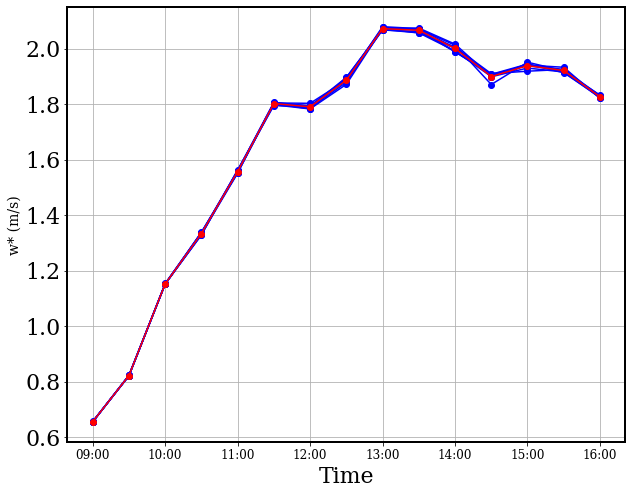

In [28]:
# 

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
#ax1.plot(time_stamp,u_star,'-o',color='black')
for i in np.arange(0,8):
    ax1.plot(time_stamp,w_star_list_iop02[i],'-o',color='blue')
ax1.plot(time_stamp,np.nanmean(w_star_list_iop02,0),'-o',color='red')


#ax1.axvline(x='13:00')
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [29]:
np.nanmean(w_star_list_iop02,0)

array([0.65544301, 0.8218802 , 1.15222044, 1.33399153, 1.55739   ,
       1.80245719, 1.79051632, 1.88647701, 2.07238861, 2.06652333,
       2.0011327 , 1.89977991, 1.93889857, 1.9215422 , 1.82642433])

In [31]:
w_star_iop02 = [0.65544301, 0.8218802 , 1.15222044, 1.33399153, 1.55739   ,
       1.80245719, 1.79051632, 1.88647701, 2.07238861, 2.06652333,
       2.0011327 , 1.89977991, 1.93889857, 1.9215422 , 1.82642433]

hom.

In [90]:
IOP02_time_array = ds_2_het_iop02.time.sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:01.200000000'))

ds_2_hom_iop02 = open_concat_member_files_hom(2,'DATA_3D_AV_NETCDF_N02slice','iop02').sel(time=slice('2019-08-23T09:00:00.000000000','2019-08-23T16:00:01.200000000')).isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))

zi_theta_av_list = []

vertical_slice = [600, 600,
                  900, 900, 1100, 1300,
                  1300, 1500, 1700, 1700,
                  1700, 1700, 1700, 1700,
                  1700 ]
for i, time_step in enumerate(IOP02_time_array):
    theta_v = ds_2_hom_iop02.theta.sel(time = time_step)*(1 + 0.61*ds_2_hom_iop02.q.sel(time = time_step))
    zi_xy_av = (theta_v.sel(zu_3d=slice(0,vertical_slice[i])).differentiate(coord = 'zu_3d', edge_order=1, datetime_unit=None).idxmax(dim='zu_3d')).mean('x').mean('y').compute()
    zi_theta_av_list.append(zi_xy_av)
zi_theta_iop02_hom = xr.concat(zi_theta_av_list,'time')

['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.07351786084473133 seconds
[########################################] | 100% Completed | 1.21 sms
[########################################] | 100% Completed | 1.31 sms
[########################################] | 100% Completed | 1.41 sms
[########################################] | 100% Completed | 1.31 sms
[########################################] | 100% Completed | 1.41 sms
[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.91 sms
[########################################] | 100% Completed | 1.71 sms
[########################################] | 100% Completed | 1.61 sms
[########################################] 

In [107]:
zi_theta_iop02_hom[4:]

<xarray.DataArray 'zu_3d' (time: 11)>
array([ 516.82318556, 1263.28327913, 1238.05916685, 1417.9678503 ,
       1570.46841613, 1542.68049009, 1562.49650256, 1588.34261528,
       1577.34207173, 1614.45957674, 1632.99747828])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T11:00:00 ... 2019-08-23T16:00:00

In [19]:
zi_theta_iop02_hom = zi_iop02_hom

In [25]:
#for the hom case
#copying values for zi here from calculated values for the cross section plots...
#

rows, cols = (8,11)
w_star_list_iop02_hom = [[0]*cols]*rows
zi_theta = np.asarray(zi_theta_iop02_hom) #values from 1100


for i,member in enumerate(np.arange(1,9)):   
    g = 9.8
    #IOP02
    ds = open_concat_member_files_hom(member,'DATA_1D_PR_NETCDF_N02slice','iop02').resample(time='30T').mean().sel(time=slice('2019-08-23T11:00:00.000000000','2019-08-23T16:00:01.200000000'))
    theta = ds.theta.sel(ztheta=0).squeeze(drop=True)
    q = ds.q.sel(zq=0).squeeze(drop=True)
    theta_v = (theta*(1 + 0.61*q)).squeeze(drop=True)

    wtheta = ds.wtheta.sel(zwtheta=0).squeeze(drop=True)
    wq  = ds.wq.sel(zwq=0).squeeze(drop=True)                                                                                                          
    wtheta_v = (wtheta + 0.61*theta*wq)


    w_star = ((((theta_v**(-1)*g)*wtheta_v)*zi_theta)**(1/3)).squeeze(drop=True)
    time_stamp =  (theta['time'].dt.strftime('%H:%M'))
    
    w_star_list_iop02_hom[member-1] = w_star.compute()

['00.ches_IOP2_parent_child1_hom1.9849', '01.ches_IOP2_parent_child1_hom1.29566', '02. ches_IOP2_parent_child1_hom1.9162', '03.ches_IOP2_parent_child1_hom1.7693']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.2443518489599228 seconds
[########################################] | 100% Completed | 103.86 ms
['01.ches_IOP2_parent_child1_hom.22675', '02.ches_IOP2_parent_child1_hom.4647']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4076922759413719 seconds
[########################################] | 100% Completed | 103.43 ms
['00.ches_IOP2_parent_child1_hom3.8694', '01.ches_IOP2_parent_child1_hom3.9492', '02.ches_IOP2_parent_child1_hom3.14926', '03.ches_IOP2_parent_child1_hom3.22232']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.7506446801126003 seconds
[########################################] | 100% Completed | 103.95 ms
['00.ches_IOP2_parent_child1_hom4.31521', '01.ches_IOP2_parent_child1_hom4.20276', '02.ches_I

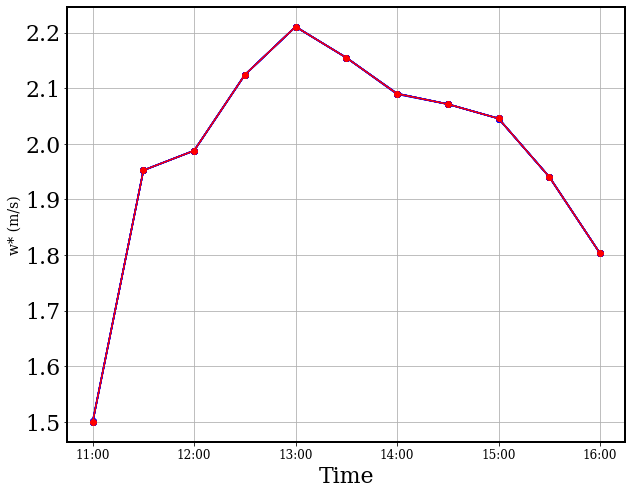

In [26]:
# 

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
#ax1.plot(time_stamp,u_star,'-o',color='black')
for i in np.arange(0,8):
    ax1.plot(time_stamp,w_star_list_iop02_hom[i],'-o',color='blue')
ax1.plot(time_stamp,np.nanmean(w_star_list_iop02_hom,0),'-o',color='red')


#ax1.axvline(x='13:00')
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [27]:
np.nanmean(w_star_list_iop02_hom,0)

array([1.49996116, 1.95223882, 1.98763838, 2.12398263, 2.21043456,
       2.15475267, 2.08991902, 2.07123293, 2.04540851, 1.94049589,
       1.80304831])

IOP03

In [21]:
zi_theta_iop03

<xarray.DataArray 'zu_3d' (time: 12)>
array([  89.55689018,  146.17518378,  222.75052796,  318.65739363,
        391.70175986,  465.53290265,  578.09552239,  665.90258855,
        747.14683894,  854.98633994,  961.446683  , 1046.67977723])
Coordinates:
  * time     (time) datetime64[ns] 2019-09-24T09:00:00 ... 2019-09-24T14:30:00

In [22]:
zi_theta_iop03 = [  88.62130987,  141.84283359,  225.54037425,  322.57451548,
        396.33941635,  475.2585832 ,  592.48186233,  679.5148229 ,
        758.12848296,  849.92848296,  958.90627311, 1030.6234217 ]


In [19]:
#I need surface buyoancy flux, thetav and zi
#calculate convective velocity scale time series

rows, cols = (8,12)
w_star_list_iop03 = [[0]*cols]*rows
zi_theta = zi_theta_iop03

for i,member in enumerate(np.arange(0,8)):   
    g = 9.8
    #IOP02
    ds = open_concat_member_files(member,'DATA_3D_AV_NETCDF_N02slice','iop03').sel(time=slice('2019-09-24T09:00:00.000000000','2019-09-24T14:30:01.200000000'),zw_3d=slice(0,100),zu_3d=slice(0,100)).isel(x=slice(x_min,x_max),y=slice(y_min,y_max),xu=slice(x_min,x_max),yv=slice(y_min,y_max))
    ds = adjust_axis(ds)
    theta = ds.theta.sel(zu_3d=36,method='nearest')#[1:]
    q = ds.q.sel(zu_3d=36,method='nearest')#[1:]
    theta_v = (theta*(1 + 0.61*q)).squeeze(drop=True)
    w_level = 36
    wtheta, wq, wtheta_v = above_canopy_fluxes(ds,w_level)
    del wtheta, wq
    wtheta_v = (wtheta_v)/(1.17*1005)

    #abl height
    #zi_wtheta = np.asarray(ts_N02_member_2_ds_iop02.zi_wtheta.sel(time=slice('2019-08-23T10:00:01.200000000','2019-08-23T16:00:01.200000000')).resample(time='30T').mean())

    w_star = (((((theta_v**(-1)*g)*wtheta_v).mean('x').mean('y'))*zi_theta)**(1/3)).squeeze(drop=True)
    time_stamp =  (theta['time'].dt.strftime('%H:%M'))
    
    w_star_list_iop03[i] = w_star.compute()

['01.ches_IOP3.14592', '02.ches_IOP3.660', '03.ches_IOP3.19260', '04.ches_IOP3.22682', '05.ches_IOP3.31133', '06.ches_IOP3.29659', '07.ches_IOP3.19900', '08.ches_IOP3.24658', '09.ches_IOP3.23660', '10.ches_IOP3.5654', '11.ches_IOP3.1905', '12.ches_IOP3.27019', '13.ches_IOP3.9399', '14.ches_IOP3.5300', '15.ches_IOP3.17284', '16.ches_IOP3.4936', '17.ches_IOP3.29670', '18.ches_IOP3.8982']
Member 0 finished collecting data
Done with member 0  Time elapsed  0.8372589088976383 seconds
[########################################] | 100% Completed | 3.53 sms
[########################################] | 100% Completed | 2.12 sms
[########################################] | 100% Completed | 907.22 ms
[########################################] | 100% Completed | 102.07 ms
['01.ches_IOP3.19457', '02.ches_IOP3.8195', '03.ches_IOP3.189', '04.ches_IOP3.4230', '05.ches_IOP3.25038', '06.ches_IOP3.10580', '07.ches_IOP3.3465', '08.ches_IOP3.7653', '09. ches_IOP3.14688']
Member 1 finished collecting data
Do

In [46]:
w_star_list_iop03

[<xarray.DataArray (time: 12)>
 array([0.2789211 , 0.72829837, 0.81147405, 0.8718969 , 0.92161486,
        1.0588264 , 1.13739468, 1.19401391, 1.22693326, 1.27869215,
        1.31368664, 1.22725588])
 Coordinates:
   * time     (time) datetime64[ns] 2019-09-24T09:00:00 ... 2019-09-24T14:30:00
     zu_3d    float64 42.0
     zw_3d    float64 36.0,
 <xarray.DataArray (time: 12)>
 array([0.28575652, 0.72650256, 0.80834223, 0.88065234, 0.94196129,
        1.08039846, 1.1723212 , 1.22066156, 1.25926327, 1.28877475,
        1.31639464, 1.22970376])
 Coordinates:
   * time     (time) datetime64[ns] 2019-09-24T09:00:00 ... 2019-09-24T14:30:00
     zu_3d    float64 42.0
     zw_3d    float64 36.0,
 <xarray.DataArray (time: 12)>
 array([0.28612935, 0.72773997, 0.80946951, 0.88364309, 0.94546453,
        1.07982301, 1.16936015, 1.22227888, 1.26210133, 1.28426839,
        1.31265765, 1.22418401])
 Coordinates:
   * time     (time) datetime64[ns] 2019-09-24T09:00:00 ... 2019-09-24T14:30:00
     zu_

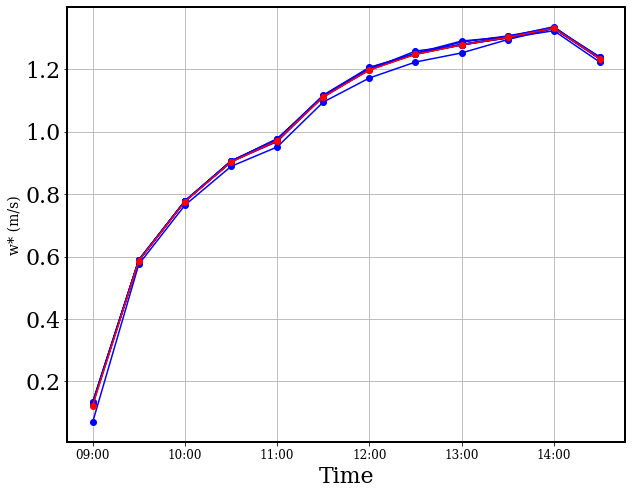

In [20]:

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
#ax1.plot(time_stamp,u_star,'-o',color='black')
for i in np.arange(0,8):
    ax1.plot(time_stamp,w_star_list_iop03[i],'-o',color='blue')
ax1.plot(time_stamp,np.nanmean(w_star_list_iop03,0),'-o',color='red')


#ax1.axvline(x='13:00')
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [21]:
np.nanmean(w_star_list_iop03,0)

array([0.12308697, 0.58652465, 0.77562798, 0.90238752, 0.970671  ,
       1.11098455, 1.19737225, 1.24688967, 1.27722204, 1.30142841,
       1.33104132, 1.23324885])

In [24]:
w_star_list_iop03 = [0.12308697, 0.58652465, 0.77562798, 0.90238752, 0.970671  ,
       1.11098455, 1.19737225, 1.24688967, 1.27722204, 1.30142841,
       1.33104132, 1.23324885]

In [26]:
# zi_iop03_hom = [ 85.71667632, 128.70966362, 186.86216084, 280.04332368,
#        365.78988639, 493.88155937, 654.26742704, 754.06946759,
#        830.85984406, 902.44667409, 950.16213856, 989.2927779 ]
zi_iop03_hom = [ 80.69513477, 126.33890844, 184.98307418, 279.36109601,
       363.49589218, 491.99541546, 652.15589218, 750.80264201,
       826.63606594, 885.59620405, 933.9983738 , 977.12602361]

In [28]:
IOP03_time_array = ['2019-09-24T09:00:00.000000000', '2019-09-24T09:30:00.000000000',
       '2019-09-24T10:00:00.000000000', '2019-09-24T10:30:00.000000000',
       '2019-09-24T11:00:00.000000000', '2019-09-24T11:30:00.000000000',
       '2019-09-24T12:00:00.000000000', '2019-09-24T12:30:00.000000000',
       '2019-09-24T13:00:00.000000000', '2019-09-24T13:30:00.000000000',
       '2019-09-24T14:00:00.000000000', '2019-09-24T14:30:00.000000000']

In [29]:
#for the hom case
#copying values for zi here from calculated values for the cross section plots...
#
rows, cols = (8,12)
w_star_list_iop03_hom = [[0]*cols]*rows
zi_theta = zi_iop03_hom #values from 1100


for i,member in enumerate(np.arange(1,9)):   
    g = 9.8
    #IOP02
    ds = open_concat_member_files_hom(member,'DATA_1D_PR_NETCDF_N02slice','iop03').resample(time='30T').mean().sel(time=IOP03_time_array)
    theta = ds.theta.sel(ztheta=0).squeeze(drop=True)
    q = ds.q.sel(zq=0).squeeze(drop=True)
    theta_v = (theta*(1 + 0.61*q)).squeeze(drop=True)

    wtheta = ds.wtheta.sel(zwtheta=0).squeeze(drop=True)
    wq  = ds.wq.sel(zwq=0).squeeze(drop=True)                                                                                                          
    wtheta_v = (wtheta + 0.61*theta*wq)

    #abl height
    #zi_wtheta = np.asarray(ts_N02_member_2_ds_iop02.zi_wtheta.sel(time=slice('2019-08-23T10:00:01.200000000','2019-08-23T16:00:01.200000000')).resample(time='30T').mean())

    w_star = (((theta_v**(-1)*g)*zi_theta*wtheta_v)**(1/3)).squeeze(drop=True)
    time_stamp =  (theta['time'].dt.strftime('%H:%M'))
    
    w_star_list_iop03_hom[member-1] = w_star.compute()

['0.ches_IOP3_parent_child1_hom1.12767', '1.ches_IOP3_parent_child1_hom1.14954']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.129881389439106 seconds
[########################################] | 100% Completed | 204.24 ms
['0.ches_IOP3_parent_child1_hom2.24067', '1.ches_IOP3_parent_child1_hom2.6737']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.1299199014902115 seconds
[########################################] | 100% Completed | 103.71 ms
['0.ches_IOP3_parent_child1_hom3.21914', '1.ches_IOP3_parent_child1_hom3.9923']
Member 3 finished collecting data
Done with member 3  Time elapsed  0.35660330206155777 seconds
[########################################] | 100% Completed | 103.34 ms
['0.ches_IOP3_parent_child1_hom4.7100', '1.ches_IOP3_parent_child1_hom4.11437']
Member 4 finished collecting data
Done with member 4  Time elapsed  0.31128254905343056 seconds
[########################################] | 100% Completed | 103.62 ms
['0.ches_I

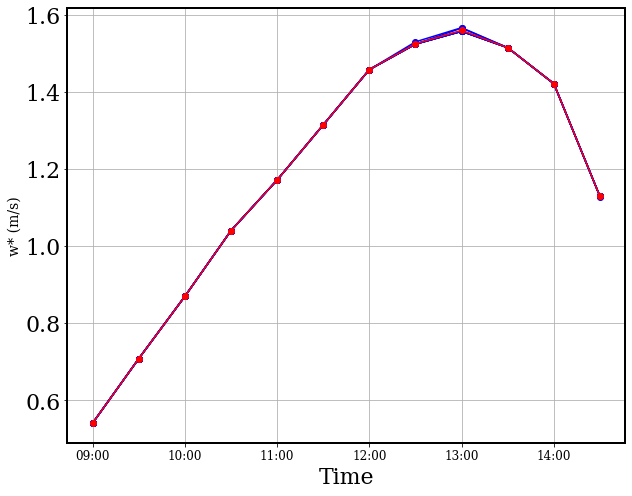

In [30]:

fig, (ax1) = plt.subplots(1,1,figsize=(10,8),sharex=True)
#ax1.plot(time_stamp,u_star,'-o',color='black')
for i in np.arange(0,8):
    ax1.plot(time_stamp,w_star_list_iop03_hom[i],'-o',color='blue')
ax1.plot(time_stamp,np.nanmean(w_star_list_iop03_hom,0),'-o',color='red')


#ax1.axvline(x='13:00')
ax1.set_ylabel('w* (m/s)',fontsize=14)
ax1.set_xlabel('Time')
tick_spacing = 2
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.tick_params(axis="x", labelsize=12)
#plt.axvline(x='13:00')
ax1.grid(True)

In [31]:
np.nanmean(w_star_list_iop03_hom,0)

array([0.54141974, 0.70868091, 0.87029157, 1.04087275, 1.17215056,
       1.31524954, 1.45871101, 1.52553778, 1.56036104, 1.51549967,
       1.42213766, 1.12934424])

In [32]:
w_star_list_iop03_hom = [0.54141974, 0.70868091, 0.87029157, 1.04087275, 1.17215056,
       1.31524954, 1.45871101, 1.52553778, 1.56036104, 1.51549967,
       1.42213766, 1.12934424]